<a href="https://colab.research.google.com/github/piusAI/DeepLearning_Basic/blob/main/Chapter04_Last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Chapter 04

#### To do this!

- 01 Sigmoid, Softmax, CEE
- 02 Gradient, Sigmoid_gradient(sigmoid differentiation)
- 03 TwoNetwork


Avartar **S**tochastic **D**escent **G**radient


#### 01 sigmoid, Softmax, CEE, Gradient
02 gradient

In [2]:
import numpy as np

def sigmoid(x):
  return 1 / (1+ np.exp(-x))

def sigmoid_gradient(x):
  return sigmoid(x) * (1 - sigmoid(x) )

def softmax(x):
  if x.ndim==2:
    x= x-np.max(x,axis=1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x),axis=1, keepdims=True)
  x = x- np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

def CEE(y,t):
  if y.ndim==1:
    y = y.reshape(y.shape[0], 1)
    t = t.reshape(t.shape[0], 1)
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t]))/ batch_size

def _numerical_gradient_no_batch(f,x):
  h=1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]
    x[idx] = float(tmp_val)+h
    fxh1 = f(x)

    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1-fxh2) / ( 2* h)
    x[idx] = tmp_val
    return grad
def numerical_gradient(f,X):
  if X.ndim == 1:
    return _numerical_gradient_no_batch(f,X)
  else:
    grad = np.zeros_like(X)
    for i, idx in enumerate(X):
      grad[i] = _numerical_gradient_no_batch(f,idx)
    return grad

####03 Two Network

In [3]:
class TwolayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std= 0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)
  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    y1 = sigmoid(a1)
    a2 = np.dot(y1, W2) + b2
    y2 = softmax(a2)
    return y2
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)

    if t.ndim != 1:
      t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def loss(self, x, t):
    y = self.predict(x)
    return CEE(y,t)

  def numerical_gradient(self, x, t):
    loss_w = lambda w : self.loss(x,t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_w, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_w, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_w, self.params['b2'])

    return grads

#역전파는 그냥 Pass
  def gradient(self, x, t):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    grads={}
    batch_num = x.shape[0]

    a1= np.dot(x,W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    if t.ndim ==1:
      t_one_hot = np.zeros_like(y)
      t_one_hot[np.arange(batch_num), t] = 1
      t = t_one_hot
    dy = (y-t) /batch_num
    grads ['W2'] = np.dot(z1.T, dy)
    grads['b2'] = np.sum(dy, axis=0)

    dz1 = np.dot(dy, W2.T)
    da1 = sigmoid_gradient(a1) * dz1
    grads['W1'] = np.dot(x.T, da1)
    grads['b1'] = np.sum(da1, axis=0)

    return grads

##여기서부터 다시

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


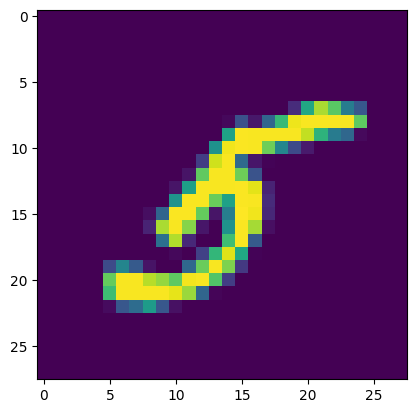

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1,784)


plt.imshow(x_train[5847].reshape(28,28))

####Stochastic GD01 - Accuracy

In [5]:
#### Stochastic GD

import numpy as np
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

### Normalize And Flatten ###
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0
#############################

train_acc_list=[]

tensor_size = x_train.shape[0]
learning_rate=1.0
iteration = 10000
batch_size = 100
network = TwolayerNet(input_size = 784, hidden_size = 50, output_size=10)

for i in range(iteration) :
  batch_mask = np.random.choice(tensor_size ,batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  accuracy = network.accuracy(x_batch, t_batch)
  train_acc_list.append(accuracy)
# print(train_acc_list)


In [6]:
print("Last Accuracy :", np.mean(train_acc_list))

Last Accuracy : 0.981894


#### Stochastic GD02 - Draw Accuracy Matplotlib !!

train acc, test acc |  0.10218333333333333 , 0.101
train acc, test acc |  0.9208666666666666 , 0.9188
train acc, test acc |  0.9486 , 0.9451
train acc, test acc |  0.9593 , 0.9562
train acc, test acc |  0.9643 , 0.9595
train acc, test acc |  0.9698833333333333 , 0.9624
train acc, test acc |  0.9741833333333333 , 0.9651
train acc, test acc |  0.9761 , 0.9668
train acc, test acc |  0.97805 , 0.9667
train acc, test acc |  0.97985 , 0.9708
train acc, test acc |  0.9812333333333333 , 0.9698
train acc, test acc |  0.9840666666666666 , 0.9711
train acc, test acc |  0.9816833333333334 , 0.9717
train acc, test acc |  0.9851833333333333 , 0.9718
train acc, test acc |  0.9863333333333333 , 0.9724
train acc, test acc |  0.9881833333333333 , 0.9714
train acc, test acc |  0.9881 , 0.9721


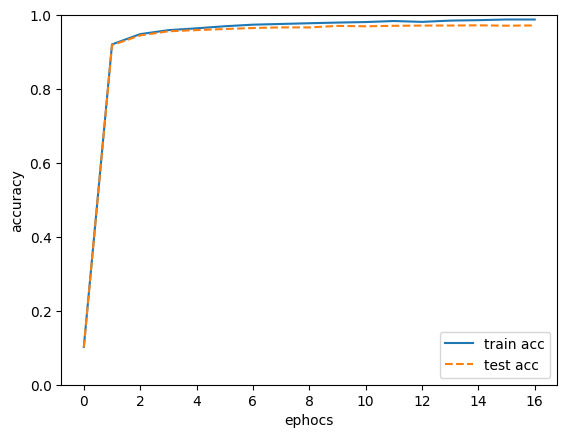

In [7]:
import numpy as np
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

learning_rate=1.0
iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
iter_per_epoch = max ( train_size / batch_size, 1)

network =TwolayerNet(input_size = 784, hidden_size= 50, output_size=10)

for i in range(iteration):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  grad = network.gradient(x_batch, t_batch)

  for key in ['W1', 'b1', 'W2', 'b2']:
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)
######GO
  if i % iter_per_epoch ==0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('train acc, test acc | ', train_acc, ',', test_acc)

markers ={'train':'o','test' : 's'}
x=np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label ='train acc')
plt.plot(x, test_acc_list, label = 'test acc', linestyle='--')

plt.xlabel('ephocs')
plt.ylabel('accuracy')

plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- DL의 학습은 Backpropagation // Numerical Gradient를 하기떄문에 느리지만,

- DL의 측정은 Predict -> argmax -> Compare로 측정하기 떄문에 매우 빠르게 측정


| 항목         | 학습 (Training)                               | 측정 (Evaluation)                       |
| ---------- | ------------------------------------------- | ------------------------------------- |
| 목적         | 모델을 업데이트하기 위한 가중치 학습                        | 모델이 얼마나 잘 맞추는지 성능 평가                  |
| 주로 사용하는 함수 | `loss()`, `gradient()`, `backpropagation()` | `predict()`, `argmax()`, `accuracy()` |
| 연산 방식      | 수치미분 / 역전파 (Backpropagation)                | 순전파만 (Forward only)                   |
| 연산량        | 매우 높음 (특히 `numerical_gradient`)             | 매우 낮음 (단순 계산)                         |
| 속도         | 느림                                          | 빠름                                    |
| 데이터 사용 방식  | 미니배치 (Mini-batch, 표본 추출)                    | 전체 데이터 사용 (Train 전체 / Test 전체)        |
| 샘플링 여부     | ✅ Yes (Stochastic Gradient Descent)         | ❌ No (모든 샘플로 정확히 측정)                  |
| 측정 빈도      | 보통 여러 번 (`epoch`마다 한 번씩)                    | 주기적으로 측정 (e.g., 1 epoch 단위)           |
| 출력 결과 예시   | 손실 값 (`loss`)                               | 정확도 (`accuracy`)                      |


train_accuracy, test_accuracy |  0.0993 , 0.1032
train_accuracy, test_accuracy |  0.9298833333333333 , 0.9316
train_accuracy, test_accuracy |  0.948 , 0.9459
train_accuracy, test_accuracy |  0.9581666666666667 , 0.9538
train_accuracy, test_accuracy |  0.9660333333333333 , 0.961
train_accuracy, test_accuracy |  0.9687166666666667 , 0.9606
train_accuracy, test_accuracy |  0.9738166666666667 , 0.9652
train_accuracy, test_accuracy |  0.9769166666666667 , 0.9667
train_accuracy, test_accuracy |  0.9765 , 0.9669
train_accuracy, test_accuracy |  0.9807 , 0.9705
train_accuracy, test_accuracy |  0.98155 , 0.9698
train_accuracy, test_accuracy |  0.98435 , 0.971
train_accuracy, test_accuracy |  0.9850333333333333 , 0.9718
train_accuracy, test_accuracy |  0.9854833333333334 , 0.9724
train_accuracy, test_accuracy |  0.9868 , 0.9707
train_accuracy, test_accuracy |  0.98795 , 0.9737
train_accuracy, test_accuracy |  0.9899166666666667 , 0.974


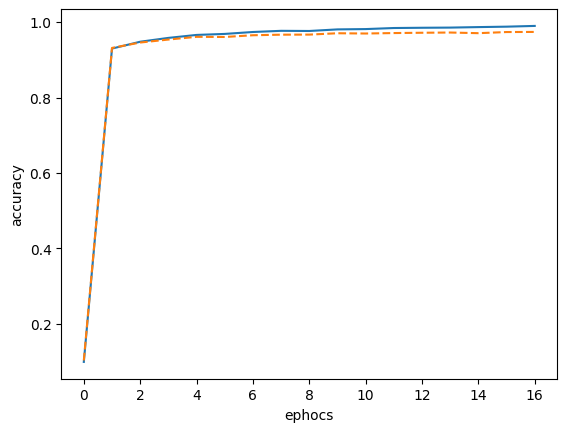

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

## normalize and flatten!
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0
##############################


train_loss_list = []
train_accuracy_list =[]
test_accuracy_list = []

iteration = 10000
batch_size = 100
learning_rate = 1.0

train_size = x_train.shape[0]

iteration_per_epoch = max( train_size / batch_size, 1)
network = TwolayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iteration):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  grad = network.gradient(x_batch, t_batch)

  for key in ['W1', 'b1', 'W2', 'b2']:
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iteration_per_epoch ==0:
    test_accuracy = network.accuracy(x_test,t_test)
    train_accuracy = network.accuracy(x_train,t_train)

    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)
    print('train_accuracy, test_accuracy | ', train_accuracy, ',', test_accuracy)

x=np.arange(len(train_accuracy_list))

plt.plot(x, train_accuracy_list, label='train acc')
plt.plot(x, test_accuracy_list, label ='test acc', linestyle='--')

plt.xlabel('ephocs')
plt.ylabel('accuracy')
plt.show()


#### Stochastic GD03 - Draw Loss Matplotlib !!

test_loss, train_loss |  2.367105247723847 ,  2.2583999002822917
test_loss, train_loss |  0.5862337107822714 ,  0.5051984530036858
test_loss, train_loss |  0.3968232444573236 ,  0.2939214288173349
test_loss, train_loss |  0.35276700492527335 ,  0.1876744864434402
test_loss, train_loss |  0.31229837326319415 ,  0.12712466871329853
test_loss, train_loss |  0.2988880307210844 ,  0.12087510451972831
test_loss, train_loss |  0.2833158575927909 ,  0.1505800319137965
test_loss, train_loss |  0.2797396732535488 ,  0.0713777104762726
test_loss, train_loss |  0.257945800410411 ,  0.08516734983342916
test_loss, train_loss |  0.24522665280307707 ,  0.1504067769462641
test_loss, train_loss |  0.24953413065872085 ,  0.09465181194918762
test_loss, train_loss |  0.2445872055553504 ,  0.05552263702271469
test_loss, train_loss |  0.23577433229578706 ,  0.06364831930916529
test_loss, train_loss |  0.22941259035376602 ,  0.09379269299871287
test_loss, train_loss |  0.23257014151865704 ,  0.100564149280358

ValueError: x and y must have same first dimension, but have shapes (100,) and (10000,)

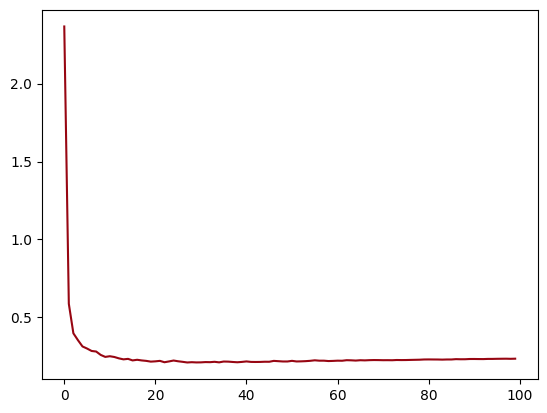

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
(x_test, t_test), (x_train, t_train) = mnist.load_data()

## normalize, flatten ##
x_test = x_test.reshape(-1, 784) / 255.0
x_train = x_train.reshape(-1, 784) / 255.0
# ------------------------------------------------ #

learning_rate = 1.0
train_size = x_train.shape[0]
batch_size = 100
iteration = 10000

train_loss_list =[]
test_loss_list =[]

iter_per_epoch = max( train_size / batch_size, 1 )

network = TwolayerNet(input_size = 784, hidden_size = 50, output_size=10)

for i in range(iteration):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)

  for key in ['W1','b1','W2','b2']:
    network.params[key] -= learning_rate * grad[key]
  train_loss = network.loss(x_batch, t_batch)
  train_loss_list.append(train_loss)
  if i % iter_per_epoch == 0:
    loss_test = network.loss(x_test, t_test)
    test_loss_list.append(loss_test)
    print("test_loss, train_loss | ", loss_test,", ",train_loss)

x=np.arange(len(test_loss_list))
plt.plot(x, test_loss_list, label='test loss', color="#970612")
plt.plot(x,train_loss_list, label='train loss', linestyle='--')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.ylim(0,1.0)
plt.legend(loc = 'lower right')
plt.show()




#### Load Mnist data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1,784)
x_test = x_train.reshape(-1, 784)

plt.imshow(x_train[2].reshape(28,28))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

### Noramlize * Flatten
# x_test = x_test.flatten() / 255.0
# x_train = x_train.flatten() / 255.0
x_test =x_test.reshape(x_test.shape[0], -1) / 255.0
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
###

train_acc_list=[]
train_loss_list=[]
test_acc_list=[]

data_size = x_train.shape[0]
learning_rate = 0.1
iteration = 10000
batch_size = 100

iteration_per_epoch = max ( data_size / batch_size, 1)

network = TwolayerNet(input_size = 784, hidden_size = 50, output_size = 10)


for i in range(iteration) :
  batch_mask= np.random.choice(data_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  grad = network.gradient(x_batch, t_batch) #Check

  for key in ('W1', 'b1','W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

### re-again!
  if i % iteration_per_epoch ==0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print("train acc, test acc | : "+ str(train_acc) + ", " + str(test_acc))

markers = {'train':'o', 'test': 's'}
x= np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')

plt.xlabel('ephocs')
plt.ylabel('accuracy')

plt.ylim(0,1.0)
plt.legend(loc='lower right')
plt.show()